# Spam vs Ham Email Classifier

## Introduction
In this class, we will utilize Logistic Regression to create a binary classifier that can distinguish spam (junk, commercial, or bulk) emails from ham (regular non-spam) emails.

This project allowed me to feel comfortable with the following:

- Feature engineering with text data.
- Using the `sklearn` library to process data and fit models.
- Validating the performance of your model and minimizing overfitting.

This first part of the project focuses on initial analysis, feature engineering, and logistic regression. In the second part of this project we built our own spam/ham classifier.

## Content Warning
This is a **real-world** dataset —— the emails we are trying to classify are actual spam and legitimate emails. As a result, some of the spam emails may be in poor taste or be considered inappropriate.

In [1]:
# Run this cell to suppress all FutureWarnings.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# More readable exceptions.
%pip install --quiet iwut
%load_ext iwut
%wut on

Note: you may need to restart the kernel to use updated packages.


### Import Statements

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# The Data

In email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. The dataset is from [SpamAssassin](https://spamassassin.apache.org/old/publiccorpus/). It consists of email messages and their labels (0 for ham, 1 for spam). Our labeled training dataset contains 8,348 labeled examples, and the unlabeled test set contains 1,000 unlabeled examples.

**Note:** The dataset is from 2004, so the contents of emails might be very different from those in 2024.

The following cells load the data into a `DataFrame`.

The `train` `DataFrame` contains labeled data we will use to train your model. It has four columns:

1. `id`: An identifier for the training example.
1. `subject`: The subject of the email.
1. `email`: The text of the email.
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam).

The `test` `DataFrame` contains 1,000 unlabeled emails.

In [3]:
import zipfile
with zipfile.ZipFile('spam_ham_data.zip') as item:
    item.extractall()

In [4]:
# Loading training and test datasets
original_training_data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Convert the emails to lowercase as the first step of text processing.
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


<br/>

First, let's check if our data contains any missing values. The cell below prints the number of `NaN` values in each column. If there are `NaN` values, we replace them with appropriate filler values (i.e., `NaN` values in the `subject` or `email` columns will be replaced with empty strings). Finally, we print the number of `NaN` values in each column after this modification to verify that there are no `NaN` values left.

**Note:** While there are no `NaN` values in the `spam` column, we should be careful when replacing `NaN` labels. Doing so without consideration may introduce significant bias into our model.

In [6]:
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    0
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


<br/>
<hr style="border: 1px solid #fdb515;" />

# Part 1: Initial Analysis

In the cell below, we have printed the text of the `email` field for the first ham and the first spam email in the original training set.

In [7]:
first_ham = original_training_data.loc[original_training_data['spam'] == 0, 'email'].iloc[0]
first_spam = original_training_data.loc[original_training_data['spam'] == 1, 'email'].iloc[0]
print("Ham Email:")
print(first_ham)
print("-------------------------------------------------")
print("Spam Email:")
print(first_spam)

Ham Email:
url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

-------------------------------------------------
Spam Email:
<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



<!-- BEGIN QUESTION -->

---
## Some things we initially noticed between the two emails


We immediately noticed that with the spam email, there are a lot of HTML tags associated with it. If it is common that spam emails contain loads of HTML tags, we could possible use them to classify if an email is a spam, or a ham. 

<!-- END QUESTION -->

## Training-Validation Split
The training data we downloaded is all the data we have available for both training models and **validating** the models that we train. We, therefore, need to split the training data into separate training and validation datasets. We will use this **validation data** to assess the performance of our classifier once we are finished training. Note that we set the seed (`random_state`) to 42. This will produce a pseudo-random sequence of random numbers that is the same each time. **Do not modify this random seed in the following questions, as our tests depend on it.**

In [8]:
# This creates a 90/10 train-validation split on our labeled data.
from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size = 0.1, random_state = 42)

<br/>
<hr style="border: 1px solid #fdb515;" />

# Part 2: Feature Engineering

We want to take the text of an email and predict whether the email is ham or spam. This is a **binary classification** problem, so we can use logistic regression to train a classifier. Recall that to train a logistic regression model, we need a numeric feature matrix $\mathbb{X}$ and a vector of corresponding binary labels $Y$. Unfortunately, our data is text, not numbers. To address this, we can create numeric features derived from the email text and use those features for logistic regression.

Each row of $\mathbb{X}$ is an email. Each column of $\mathbb{X}$ contains one feature for all the emails. We'll go through creating some simple feature, and then create more interesting ones as we try to increase the accuracy of our model.

<br>

---

Here we create a function `words_in_texts` that takes in a list of interesting words (`words`) and a `Series` of emails (`texts`). Our goal is to check if each word in `words` is contained in the emails in `texts`.

The `words_in_texts` function outputs a **2-dimensional `NumPy` array** that contains one row for each email in `texts` and one column for each word in `words`. If the $j$-th word in `words` is present at least once in the $i$-th email in `texts`, the output array should have a value of 1 at the position $(i, j)$. Otherwise, if the $j$-th word is not present in the $i$-th email, the value at $(i, j)$ should be 0.

Later, we will be applying `words_in_texts` to some large datasets, so implementing some form of vectorization (for example, using `NumPy` arrays, `Series.str` functions, etc.) is most optimal.

For example:
```
>>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])
```

Importantly, we **do not** calculate the *number of occurrences* of each word; only if the word is present at least *once*. Take a moment to work through the example on your own if need be —— understanding what the function does is a critical first step in implementing it.

*The provided tests make sure that your function works correctly so that you can use it for future questions.*

In [118]:
def words_in_texts(words, texts):
    """
    Args:
        words (list): Words to find.
        texts (Series): Strings to search in.
    
    Returns:
        A 2D NumPy array of 0s and 1s with shape (n, d) where 
        n is the number of texts, and d is the number of words.
    """

    indicator_array = np.array([texts.str.contains(word) for word in words]).astype(int).T
    return indicator_array

In [119]:
# Run this cell to see what your function outputs. Compare the results to the example provided above.
words_in_texts(['hello', 'bye', 'world'], pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])

In [120]:
grader.check("q2")

q2 results: All test cases passed!

<br/>
<hr style="border: 1px solid #fdb515;" />

# Part 3: EDA

We need to identify some features that allow us to distinguish spam emails from ham emails. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. Suppose the feature is a binary indicator, such as whether a particular word occurs in the text. In that case, this compares the proportion of spam emails with the word to the proportion of ham emails with the word.

The following plot (created using `sns.barplot`) compares the proportion of emails in each class containing a particular set of words. The bars colored by email class were generated by setting the `hue` parameter of `sns.barplot` to a column containing the class (spam or ham) of each data point. An example of how this class column was created is shown below:

![training conditional proportions](images/training_conditional_proportions.png)

You can use `DataFrame`'s `.melt` ([documentation](https://pandas.pydata.org/pandas-docs/version/1.4/reference/api/pandas.melt.html)) method to "unpivot" a `DataFrame`. See the following code cell for an example.

In [121]:
from IPython.display import display, Markdown
df = pd.DataFrame({
    'word_1': [1, 0, 1, 0],
    'word_2': [0, 1, 0, 1],
    'type': ['spam', 'ham', 'ham', 'ham']
})
display(Markdown("> Our original `DataFrame` has a `type` column and some columns corresponding to words. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurrences of the word in this sentence."))
display(df);
display(Markdown("> `melt` will turn columns into entries in a variable column. Notice how `word_1` and `word_2` become entries in `variable`; their values are stored in the `value` column."))
display(df.melt("type"))

> Our original `DataFrame` has a `type` column and some columns corresponding to words. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurrences of the word in this sentence.

,word_1,word_2,type
0,1,0,spam
1,0,1,ham
2,1,0,ham
3,0,1,ham


> `melt` will turn columns into entries in a variable column. Notice how `word_1` and `word_2` become entries in `variable`; their values are stored in the `value` column.

,type,variable,value
0,spam,word_1,1
1,ham,word_1,0
2,ham,word_1,1
3,ham,word_1,0
4,spam,word_2,0
5,ham,word_2,1
6,ham,word_2,0
7,ham,word_2,1


<br>

---

## Question 3

Create the bar chart above by comparing the proportion of spam and ham emails containing specific words. **Choose a set of 6 words other than those shown in the example.** These words should have different proportions for the two classes (i.e., noticeably different bar heights across spam and ham). Make sure only to consider emails from `train`. Your `words_in_texts` function from the previous part will be useful here. 

**Hint:** This is a pretty challenging question. The suggested approach is to first look at the example bar plot and make sure you can interpret what is being plotted - what does a bar represent? What does the height mean? 

Next, see how to make this plot with `sns.barplot`. Take a look at the [documentation](https://seaborn.pydata.org/generated/seaborn.barplot.html) and determine what the inputs should be. A possible data input is given below:
<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>type</th>      <th>variable</th>      <th>value</th>    </tr>  </thead>  <tbody>    
<tr>      <th>0</th>      <td>Ham</td>      <td>word_1</td>      <td>0.021269</td>    </tr>    
<tr>      <th>1</th>      <td>Ham</td>      <td>word_2</td>      <td>0.101519</td>    </tr>    
<tr>      <th>2</th>      <td>Spam</td>      <td>word_3</td>      <td>0.059160</td>    </tr>    
<tr>      <th>3</th>      <td>Spam</td>      <td>word_2</td>      <td>0.017694</td>    </tr>    
<tr>      <th>4</th>      <td>Ham</td>      <td>word_4</td>      <td>0.013226</td>    </tr>     
<tr>      <th>...</th>      <td>...</td>      <td>...</td>      <td>...</td>    </tr>    
</tbody></table>

Finally, you will need to chain some `pandas` functions together. Try to add one function at a time and see how that affects the `DataFrame`. It may help to use a new cell or print out the `DataFrame` for debugging purposes as you work towards achieving the desired format above.

<!-- BEGIN QUESTION -->

Create your bar chart in the following cell:

In [122]:
list_words = ["<br>", "sale", "buy", "hot", "purchase", "now!"]
text_series = train["email"]
jin = words_in_texts(list_words, text_series)

df = pd.DataFrame(jin)
df.columns = list_words
df["type"] = train["spam"]
gyatt = df.groupby("type").agg("mean")
gyatt["type"] = pd.Series(["Ham", "Spam"])
gyatt.melt("type")

,type,variable,value
0,Ham,<br>,0.159952
1,Spam,<br>,0.143685
2,Ham,sale,0.059734
3,Spam,sale,0.056779
4,Ham,buy,0.088510
5,Spam,buy,0.084009
6,Ham,hot,0.104584
7,Spam,hot,0.099652
8,Ham,purchase,0.045446
9,Spam,purchase,0.037659


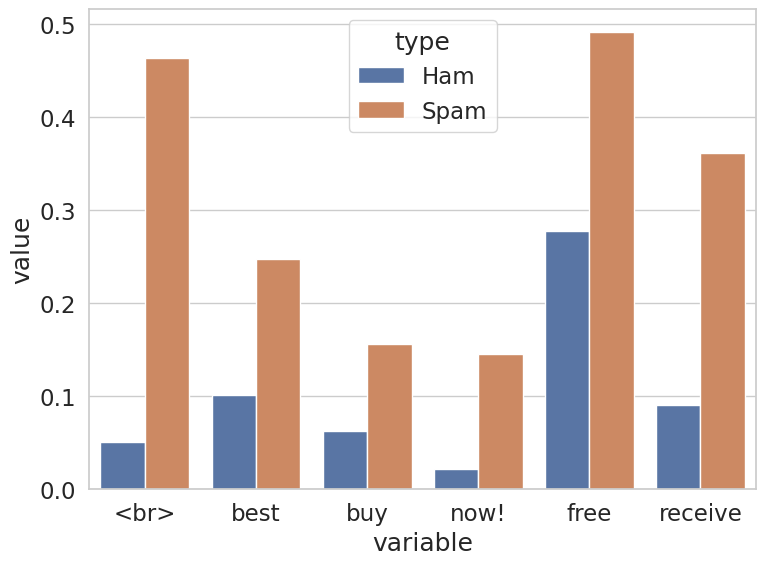

In [123]:
train = train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts.
plt.figure(figsize=(8,6))

list_words = ["<br>", "best", "buy", "now!", "free", "receive"]
text_series = train["email"]
jin = words_in_texts(list_words, text_series)

df = pd.DataFrame(jin)
df.columns = list_words
df["type"] = train["spam"]
gyatt = df.groupby("type").agg("mean")
gyatt["type"] = pd.Series(["Ham", "Spam"])
gyatt = gyatt.melt("type")

sns.barplot(data = gyatt, x = "variable", y = "value", hue = "type")


plt.tight_layout()
plt.show()

<!-- END QUESTION -->

When the feature is binary, it makes sense to compare its proportions across classes (as in the previous question). Otherwise, if the feature can take on numeric values, we can compare the distributions of these values for different classes. 

<br/>
<hr style="border: 1px solid #fdb515;" />

# Part 4: Basic Classification

Notice that the output of `words_in_texts(words, train['email'])` is a numeric matrix containing features for each email. This means we can use it directly to train a classifier!

<br>

---

## Question 4

We've given you 5 words that might be useful as features to distinguish spam/ham emails. Use these words and the `train` `DataFrame` to create two `NumPy` arrays: `X_train` and `Y_train`. `X_train` should be a 2D array of 0s and 1s created using your `words_in_texts` function on all the emails in the training set. `Y_train` should be a vector of the correct labels for each email in the training set.

*The provided tests check that the dimensions of your design matrix ($\mathbb{X}$) are correct and that your features and labels are binary (i.e., consist only of 0s and 1s). It does not check that your function is correct; that was verified in Question 2.*

In [124]:
X_train.shape

(7513, 5)

In [125]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train["email"])
Y_train = np.array(train["spam"])

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 array([0, 0, 0, 0, 0]))

In [126]:
grader.check("q4")

q4 results: All test cases passed!

<br>

---
## Question 5

Now that we have matrices, we can build a model with `sklearn`! Using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, train a logistic regression model using `X_train` and `Y_train`. Then, output the model's training accuracy below. You should get an accuracy of around $0.76$.

*The provided tests check that you initialized your logistic regression model correctly.*

In [127]:
from sklearn.linear_model import LogisticRegression

my_model = LogisticRegression()
my_model.fit(X_train, Y_train)

predicted_y = my_model.predict(X_train)

training_accuracy = my_model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


In [128]:
grader.check("q5")

q5 results: All test cases passed!

<br/>
<hr style="border: 1px solid #fdb515;" />

# Part 5: Evaluating Classifiers

That doesn't seem too shabby! But the classifier you made above isn't as good as the accuracy would make you believe. First, we are evaluating the accuracy of the model on the training set, which may be a misleading measure. Accuracy on the training set doesn't always translate to accuracy in the real world (on the test set). In future parts of this analysis, we will make use of the data we held out for model validation and comparison.

Presumably, our classifier will be used for **filtering**, or preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- **False positive (FP)**: A ham email gets flagged as spam and filtered out of the inbox.
- **False negative (FN)**: A spam email gets mislabeled as ham and ends up in the inbox.

To be clear, we label spam emails as 1 and ham emails as 0. These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier in addition to overall accuracy:

**Precision**: Measures the proportion of emails flagged as spam that are actually spam. Mathematically, $\frac{\text{TP}}{\text{TP} + \text{FP}}$.

**Recall**: Measures the proportion  of spam emails that were correctly flagged as spam. Mathematically, $\frac{\text{TP}}{\text{TP} + \text{FN}}$.

**False positive rate**: Measures the proportion  of ham emails that were incorrectly flagged as spam. Mathematically, $\frac{\text{FP}}{\text{FP} + \text{TN}}$.

One quick mnemonic to remember the formulas is that **P**recision involves T**P** and F**P**, Recall does not. In the final, the reference sheet will also contain the formulas shown above, but you should be able to interpret what they mean and their importance depending on the context.

The below graphic (modified slightly from [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)) may help you understand precision and recall visually:<br />
<center>
<img alt="precision_recall" src="images/precision_recall.png" width="600px" />
</center>

Note that a True Positive (TP) is a spam email that is classified as spam, and a True Negative (TN) is a ham email that is classified as ham.

<br>

---

## Question 6a

Suppose we have a hypothetical classifier called the “zero predictor.” For any inputted email, the zero predictor *always* predicts 0 (it never makes a prediction of 1 for any email). How many false positives and false negatives would this classifier have if it were evaluated on the training set and its results were compared to `Y_train`? Assign `zero_predictor_fp` to the number of false positives and `zero_predictor_fn` to the number of false negatives for the hypothetical zero predictor on the training data.

*The public tests only check that you have assigned appropriate types of values to each response variable but do not check that your answers are correct. That is, we only check that the number of false positives and false negatives should be greater than or equal to 0.*

In [129]:
zero_predictor_fp = 0
zero_predictor_fn = sum(Y_train)
zero_predictor_fp, zero_predictor_fn

(0, 1918)

In [130]:
grader.check("q6a")

q6a results: All test cases passed!

<br>

---

## Question 6b

What is the accuracy and recall of the zero predictor on the training data? Do not use any `sklearn` functions to compute these performance metrics.

*The public tests only check that you have assigned appropriate types of values to each response variable but do not check that your answers are correct. That is, we only check that proportions or percentages (like precision, recall, accuracy) lie in the interval [0, 1].*

In [131]:
zero_predictor_acc = (len(Y_train) - sum(Y_train))/ len(Y_train)
zero_predictor_recall = 0
zero_predictor_acc, zero_predictor_recall

(0.7447091707706642, 0)

In [132]:
grader.check("q6b")

q6b results: All test cases passed!

<!-- BEGIN QUESTION -->

<br>

---

## Question 6c

Explain your results in `q6a` and `q6b`. How did you know what to assign to `zero_predictor_fp`, `zero_predictor_fn`, `zero_predictor_acc`, and `zero_predictor_recall`?

For `zero_predcitor_fp`, we know to put 0 as since this classifier never outputs any 1s, or in other words in never outputs any positive values, then the proportion of false positives must inherently be 0. For `zero_predictor_fn`, I put the sum of our Y_train, or the number of original 1's in our training data, as the number of false negatives. This is because since our classifier always outputs 0, then all of the original 1's in the original data will be predicted incorrectly. For `zero_predictor_acc`, I found the number of 0s and divided by the total number of data points. I did this because accuracy is defined as the number of points that were identified correctly. Since this classifier only outputs 0, then the proportion of 0s in the entire training data will also be its accuracy. Finally we have `zero_predictor_recall`. I put 0 here because the formula for recall is the number of true positives / number of predicted positives. However, since our classifier will only ever output 0, there will never be this notion of "true positive", as 1 can never be an output. 

<!-- END QUESTION -->

<br/>

---

## Question 6d

Compute the precision, recall, and false positive rate of the `LogisticRegression` classifier `my_model` from Question 5. Do **not** use any `sklearn` functions to compute performance metrics; the only `sklearn` method you may use here is `.predict` to generate model predictions using `my_model` and `X_train`.

*The public tests only check that you have assigned appropriate types of values to each response variable but do not check that your answers are correct. That is, we only check that proportions or percentages (like precision, recall, false positive rate) lie in the interval [0, 1].*

In [133]:
Y_train_hat = my_model.predict(X_train)

TP = sum(Y_train_hat + Y_train == 2)
TN = sum(Y_train_hat + Y_train == 0) 
FP = sum(Y_train_hat - Y_train == 1)
FN = sum(Y_train_hat - Y_train == -1)
logistic_predictor_precision = TP / (TP + FP)
logistic_predictor_recall = TP/ (TP + FN)
logistic_predictor_fpr = FP/ (FP + TN)

print(f"{TP=}, {TN=}, {FP=}, {FN=}")
print(f"{logistic_predictor_precision=:.2f}, {logistic_predictor_recall=:.2f}, {logistic_predictor_fpr=:.2f}")

TP=219, TN=5473, FP=122, FN=1699
logistic_predictor_precision=0.64, logistic_predictor_recall=0.11, logistic_predictor_fpr=0.02


In [134]:
grader.check("q6d")

q6d results: All test cases passed!

<br>

---

## Question 6e

Is the number of false positives produced by the logistic regression classifier `my_model` strictly greater than the number of false negatives produced? Assign to `q6e` an expression that evaluates to give your answer (`True` or `False`). 

In [135]:
q6e = False
q6e

False

In [136]:
grader.check("q6e")

q6e results: All test cases passed!

<!-- BEGIN QUESTION -->

<br>

---

## Question 6f

How does the accuracy of the logistic regression classifier `my_model` compare to the accuracy of the zero predictor?

They are around the same, with an accuracy for both models being around 0.75. This indicates that the accuracy of `my_model` is essentially the same as if we were strictly classifying each email as not spam. Thus showing how accuracy may not be the best metric in determining how good a classifier is.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

---

## Question 6g

Given the word features provided in Question 4, discuss why the logistic regression classifier `my_model` may be performing poorly. 

**Hint:** Think about how prevalent these words are in the email set.

One reason the regression classifier `my_model` is doing so poorly is that we just haven't picked words that are good enough to distinguish between spam or ham. Essentially, this could be happening because most of our words were associated with non-spam emails. There wouldn't be that much of a way to distinguish a spam vs ham email if most of the words we used were associated with non-spam. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

---

## Question 6h

Would you prefer to use the logistic regression classifier `my_model` or the zero predictor classifier for a spam filter? Why? Describe your reasoning and relate it to at least one of the evaluation metrics you have computed so far.

While it is close, I would select `my_model`. This is because the number of false negatives in `my_model` is a bit lower than the zero predictor's false negatives. `my_model` experienced 1699 false negatives and the zero predictors had 1918. I chose false negatives specifically since I think it is costly to accidentally misidentify an email as spam, and never seeing it, when in reality it wasn't spam. Thus, I chose the model which had the lower number of false negatives. 

<!-- END QUESTION -->

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Nori and Ella congratulate you for finishing Project B1!
<div align="middle">
    <table style="width:100%">
      <tr align="center">
        <td><video controls src = "images/nori_snow.MP4" width = "250">animation</video>
        </td>
        <td><img src="images/ella.png" align="middle" width="325vw" />
      </tr>
    </table>
  </div>

What's next? In Project B2, you will focus on building a spam/ham email classifier with logistic regression. You will be well-prepared to build such a model: you have considered what is in this data set, what it can be used for, and engineered some features that should be useful for prediction.

### Course Content Feedback

If you have any feedback about this assignment or about any of our other weekly, weekly assignments, lectures, or discussions, please fill out the [Course Content Feedback Form](https://docs.google.com/forms/d/e/1FAIpQLSe0fBEJwt6aEfZxU3fh3llNk8rSWHj6Umq0km3wPqmFu0MlGA/viewform). Your input is valuable in helping us improve the quality and relevance of our content to better meet your needs and expectations!

### Submission Instructions

Below, you will see a cell. Running this cell will automatically generate a zip file with your autograded answers. Once you submit this file to the Project B1 Coding assignment on Gradescope, Gradescope will automatically submit a PDF file with your written answers to the Project B1 Written assignment. If you run into any issues when running this cell, feel free to check this [section](https://ds100.org/debugging-guide/autograder_gradescope/autograder_gradescope.html#why-does-grader.exportrun_teststrue-fail-if-all-previous-tests-passed) in the Data 100 Debugging Guide.

If there are issues with automatically generating the PDF, please check this [section](https://ds100.org/debugging-guide/jupyter_datahub/jupyter_datahub.html#i-cant-export-my-assignment-as-a-pdf-due-to-a-latexfailed-error) of the Debugging Guide for alternative options.

**You are responsible for ensuring your submission follows our requirements and that everything was generated and submitted correctly. We will not be granting regrade requests nor extensions to submissions that don't follow instructions.** If you encounter any difficulties with submission, please don't hesitate to reach out to staff prior to the deadline. 

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [137]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q2 results: All test cases passed!

    q4 results: All test cases passed!

    q5 results: All test cases passed!

    q6a results: All test cases passed!

    q6b results: All test cases passed!

    q6d results: All test cases passed!

    q6e results: All test cases passed!


In [65]:
# Initialize Otter
import otter
grader = otter.Notebook("projB2.ipynb")

# Project B2: Spam/Ham Classification - Build Your Own Model

## Feature Engineering, Classification, and Cross-Validation
## Due Date: Thursday, April 25th, 11:59 PM PDT

You must submit this assignment to Gradescope by the on-time deadline, Thursday, April 25th, 11:59 PM. Please read the syllabus for the grace period policy. No late submissions beyond the grace period will be accepted. **We strongly encourage you to plan to submit your work to Gradescope several hours before the stated deadline.** This way, you will have ample time to reach out to staff for submission support. While course staff is happy to help you if you encounter difficulties with submission, we may not be able to respond to last-minute requests for assistance (TAs need to sleep, after all!).

Please read the instructions carefully when submitting your work to Gradescope. 

## Collaboration Policy

Data science is a collaborative activity. While you may talk with others about the project, we ask that you **write your solutions individually**. If you do discuss the assignments with others, please **include their names** in the collaborators cell below.

**Collaborators**: *list collaborators here*

## Introduction
In this project, you will build and improve on the concepts and functions you implemented in Project B1 to create your own classifier to distinguish spam emails from ham (non-spam) emails. We will evaluate your work based on your model's accuracy and written responses in this notebook.

After this assignment, you should feel comfortable with the following:

- Using `sklearn` libraries to process data and fit classification models.
- Validating the performance of your model and minimizing overfitting.
- Generating and analyzing ROC curves.

## Content Warning
This is a **real-world** dataset —— the emails you are trying to classify are actual spam and legitimate emails. As a result, some of the spam emails may be in poor taste or be considered inappropriate. We think the benefit of working with realistic data outweighs these inappropriate emails, but we wanted to warn you at the beginning of the project so that you are made aware.

If you feel uncomfortable with this topic, **please contact your TA, the instructors, or reach out via the [Spring 2024 extenuating circumstances form](https://forms.gle/HFdpmHzBu1e7zcF2A).**

In [66]:
# Run this cell to suppress all FutureWarnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Grading
Grading is broken down into autograded answers and free responses. 

For autograded answers, the results of your code are compared to provided and/or hidden tests.

For free response questions, readers will evaluate how well you answered the question and/or fulfilled the requirements of the question.

Question | Manual | Points
----|----|----
1a | Yes | 4
1b | Yes | 2
2 | No | 0
3a | No | 5
3b | No | 10
4 | Yes | 6
5 | Yes | 3
6a | Yes | 3
6b | Yes | 2
7ai | No | 1
7aii | Yes | 1
7bi | Yes | 1
7bii | Yes | 1
7c | Yes | 1
7d | Yes | 2
7e | Yes | 2
Total | 12 | 44

## Before You Start

For each question in the assignment, please write down your answer in the answer cell(s) right below the question. 

We understand that it is helpful to have extra cells breaking down the process of reaching your final answer. If you happen to create new cells below your answer to run code, **NEVER** add cells between a question cell and the answer cell below it. It will cause errors when we run the autograder, and it will sometimes cause a failure to generate the PDF file.

**Important note: The local autograder tests will not be comprehensive. You can pass the automated tests in your notebook but still fail tests in the autograder.** Please be sure to check your results carefully.

### Debugging Guide
If you run into any technical issues, we highly recommend checking out the [Data 100 Debugging Guide](https://ds100.org/debugging-guide/). This guide contains general questions about Jupyter notebooks / Datahub, Gradescope, common `pandas` errors, RegEx, visualizations, and more.

In [67]:
import numpy as np
import pandas as pd
import sys

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

from datetime import datetime
from IPython.display import display, HTML

<br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Setup and Recap

Here, we will provide a summary of Project B1 to remind you of how we cleaned the data, explored it, and implemented methods helpful in building your own model.

## Loading and Cleaning Data

Remember that in the email classification task, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). Your labeled training dataset contains 8,348 labeled examples, and the unlabeled test set contains 1,000 unlabeled examples.

Run the following cell to load the data into a `DataFrame`.

The `train` `DataFrame` contains labeled data that you will use to train your model. It contains four columns:

1. `id`: An identifier for the training example.
1. `subject`: The subject of the email.
1. `email`: The text of the email.
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam).

The `test` `DataFrame` contains 1,000 unlabeled emails. You will predict labels for these emails and submit your predictions to the autograder for evaluation.

In [68]:
import zipfile
with zipfile.ZipFile('spam_ham_data.zip') as item:
    item.extractall()

In [69]:
original_training_data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Convert the emails to lowercase as the first step of text processing.
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


Feel free to explore the dataset above along with any specific spam and ham emails that interest you. Keep in mind that our data may contain missing values, which are handled in the following cell.

In [70]:
# Fill any missing or NAN values.
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


## Training/Validation Split

Recall that the training data we downloaded is all the data we have available for both training models and **validating** the models that we train. Therefore, we split the training data into separate training and validation datasets. Once you have finished training, you will need this validation data to assess the performance of your classifier. 

As in Project B1, we set the seed (`random_state`) to 42. **Do not modify this in the following questions, as our tests depend on this random seed.**

In [71]:
# This creates a 90/10 train-validation split on our labeled data.
from sklearn.model_selection import train_test_split
train, val = train_test_split(original_training_data, test_size = 0.1, random_state = 42)

# We must do this in order to preserve the ordering of emails to labels for words_in_texts.
train = train.reset_index(drop = True)

## Feature Engineering

We need a numeric feature matrix $\mathbb{X}$ and a vector of corresponding binary labels $\mathbb{Y}$ to train a logistic regression model. In Project B1, we implemented the function `words_in_texts`, which creates numeric features derived from the email text and uses those features for logistic regression. 

For this project, we have provided you with an implemented version of `words_in_texts`. Remember that the function outputs a 2-dimensional `NumPy` array containing one row for each email text. The row should contain a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. 

Run the following cell to see how the function works on some text.

In [72]:
from utils.pyc import words_in_texts

words_in_texts(['hello', 'bye', 'world'], pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])

## EDA and Basic Classification

In Project B1, we visualized the frequency of different words in spam and ham emails and used `words_in_texts(words, train['email'])` to train a classifier directly. We also provided a simple set of 5 words that might be useful as features to distinguish spam/ham emails. 

We then built a model using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier from `sklearn`.

Run the following cell to see the performance of a simple model using these words and the `train` `DataFrame`.

In [73]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = np.array(train['spam'])

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 array([0, 0, 0, 0, 0]))

In [74]:
from sklearn.linear_model import LogisticRegression

simple_model = LogisticRegression()
simple_model.fit(X_train, Y_train)

training_accuracy = simple_model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


## Evaluating Classifiers

In our models, we evaluate the accuracy of the training set, which may provide a misleading accuracy measure. In Project B1, we calculated various metrics to consider other ways of evaluating a classifier, in addition to overall accuracy. Below is a reference to those concepts.

Presumably, our classifier will be used for **filtering**, or preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- **False positive (FP)**: A ham email gets flagged as spam and filtered out of the inbox.
- **False negative (FN)**: A spam email gets mislabeled as ham and ends up in the inbox.

To be clear, we label spam emails as 1 and ham emails as 0. These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier in addition to overall accuracy:

**Precision**: Measures the proportion of emails flagged as spam that are actually spam. Mathematically, $\frac{\text{TP}}{\text{TP} + \text{FP}}$.

**Recall**: Measures the proportion  of spam emails that were correctly flagged as spam. Mathematically, $\frac{\text{TP}}{\text{TP} + \text{FN}}$.

**False positive rate**: Measures the proportion  of ham emails that were incorrectly flagged as spam. Mathematically, $\frac{\text{FP}}{\text{FP} + \text{TN}}$.

The below graphic (modified slightly from [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)) may help you understand precision and recall visually:<br />
<center>
<img alt="precision_recall" src="precision_recall.png" width="600px;" />
</center>

Note that a True Positive (TP) is a spam email that is classified as spam, and a True Negative (TN) is a ham email that is classified as ham.

<br/>
<hr style="border: 1px solid #fdb515;" />

# Moving Forward

With this in mind, it is now your task to make the spam filter more accurate. To get full credit on the accuracy part of this assignment, you must get at least **85%** accuracy on both the train and test set (see Question 3 for the partial credit breakdown). To determine your accuracy on the test set, you will use your classifier to predict every email in the `test` `DataFrame` and upload your predictions to Gradescope.

**You will only be able to submit your test set predictions to Gradescope up to 4 times per day**. You will be able to see your accuracy on the entire test set when submitting to Gradescope. Note that attempts will not carry over across days, so we recommend planning ahead to make sure you have enough time to finetune your model! In the case that you are approved for an extension, you are granted 4 more submissions for each day the deadline has been extended.

Here are some ideas for improving your model:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject/body
    1. Number of words in the subject/body
    1. Use of punctuation (e.g., how many '!'s were there?)
    1. Number/percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. Alternatively, you can identify misclassified emails and see which relevant words are missing in your model.
1. Reducing dimensionality and/or multicollinearity. There are a few methods to achieve this:
    1. Implement PCA. Lectures [24](https://ds100.org/sp24/lecture/lec24/) and [25](https://ds100.org/sp24/lecture/lec25/) may be helpful.
    1. Interpret the model coefficients. Note that a feature will be more valuable in classification if its coefficient has a larger **absolute** value. If the coefficient has a lower **absolute** value, the feature likely isn't valuable in classifying emails.
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust the parameters of your model (e.g. the penalty type, the regularization parameter, or any arguments in `LogisticRegression`) to achieve higher accuracy. Recall that you should use cross-validation for feature and model selection! Otherwise, you will likely overfit to your training data.
    1. Consider implementing L1 regularization. The [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for `LogisticRegression` may be helpful here. 
    1. We have imported `GridSearchCV` for you. You may use sklearn's `GridSearchCV` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)) class to perform cross-validation. You do not need to code cross-validation from scratch, though you are welcome to do so.

Here's an example of how to use `GridSearchCV`. Suppose we wanted to experiment with 4 different solvers (numerical methods for optimizing the mode) models for a `LogisticRegression` model `lr_model`. 
1. We could define a dictionary specifying the hyperparameters and the specific values we want to try out like so: `parameters = {'solver':[{'lbfgs', 'liblinear', 'newton-cg', 'saga']}`.
2. Running `grid = GridSearchCV(estimator=lr_model, param_grid=parameters)` would give us a model for each combination of hyperparameters we are testing - in this case, just 4 models.
3. We fit each model to some training data `X_train` and `Y_train` using `grid_result = grid.fit(X_train, Y_train)`.
4. Indexing into `grid_result.cv_results_` with a particular metric (in this case, `mean_test_score`), we get an array with the scores corresponding to each of the models. `grid_result.cv_results_['mean_test_score']`.
Feel free to experiment with other hyperparameters and metrics as well. The documentation is your friend!     
       
You may use whatever method you prefer to create features, but **you may only use the packages we've imported for you in the cell below or earlier in this notebook**. In addition, **you are only allowed to train logistic regression models**. No decision trees, random forests, k-nearest-neighbors, neural nets, etc. 

**Note 1:** You may want to use your **validation data** to evaluate your model and get a better sense of how it will perform on the test set. However, you may overfit to your validation set if you try to optimize your validation accuracy too much. Alternatively, you can perform cross-validation on the entire training set.

**Note 2:** If you see a `ConvergenceWarning`, increase the maximum number of iterations the model runs for by passing in a parameter, `max_iter`, into `LogisticRegression()`. This should get rid of the warning. For a longer discussion on why this warning appears, you might find [this StackOverflow post](https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter) helpful. Convergence of solvers is not in scope for Data 100, but by understanding what the error messages are saying, you can get some useful context on what to do in these situations.

<br/>
<hr style="border: 1px solid #fdb515;" />

# Question 1: Exploratory Data Analysis

To decide which features to use when building your model, it is helpful to conduct EDA. Show a visualization you used to select features for your model. 

Please include:

1. A plot showing something meaningful about the data that helped you during feature selection, model selection, or both.
2. Two or three sentences describing what you plotted and its implications with respect to your features.

You can create as many plots as you want in your feature selection process, but you should select only one for the response question below.

**You should not just produce an identical visualization to Question 3 in Project B1.** For this section, we’d like you to go beyond the analysis you performed in Project B1. Choose some plot other than the 1-dimensional distribution of some quantity for spam and ham emails. In particular, do not produce a bar plot of proportions like you created in Question 3 of Project B1. Any other plot is acceptable, **as long as it comes with thoughtful commentary.** Here are some ideas:

1. Consider the correlation between multiple features (look up correlation plots and `sns.heatmap` ([documentation](https://seaborn.pydata.org/generated/seaborn.heatmap.html))). 
1. Try to show redundancy in a group of features (e.g., `body` and `html` might co-occur relatively frequently, or you might be able to design a feature that captures all HTML tags and compares them to these). 
1. Visualize which words have high or low values for helpful statistics.
1. Visually depict whether spam emails tend to be wordier (in some sense) than ham emails.

<!-- BEGIN QUESTION -->

<br>

---

## Question 1a

Generate your visualization in the cell below.


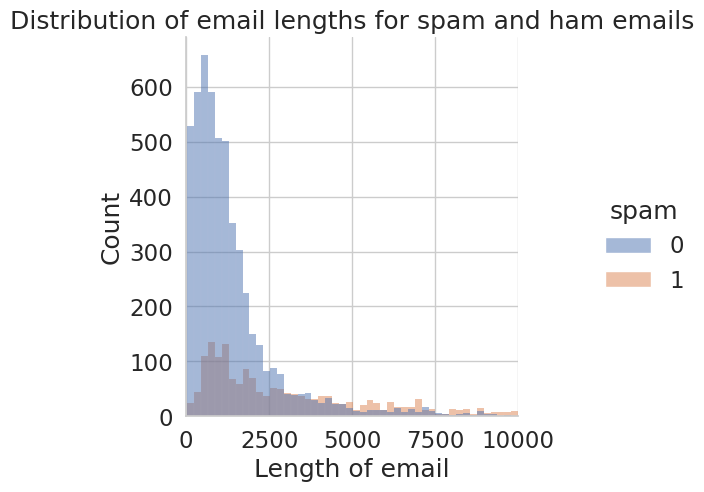

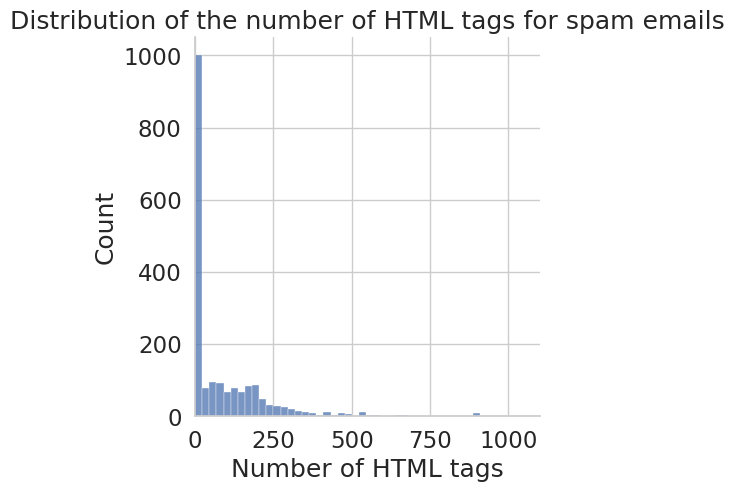

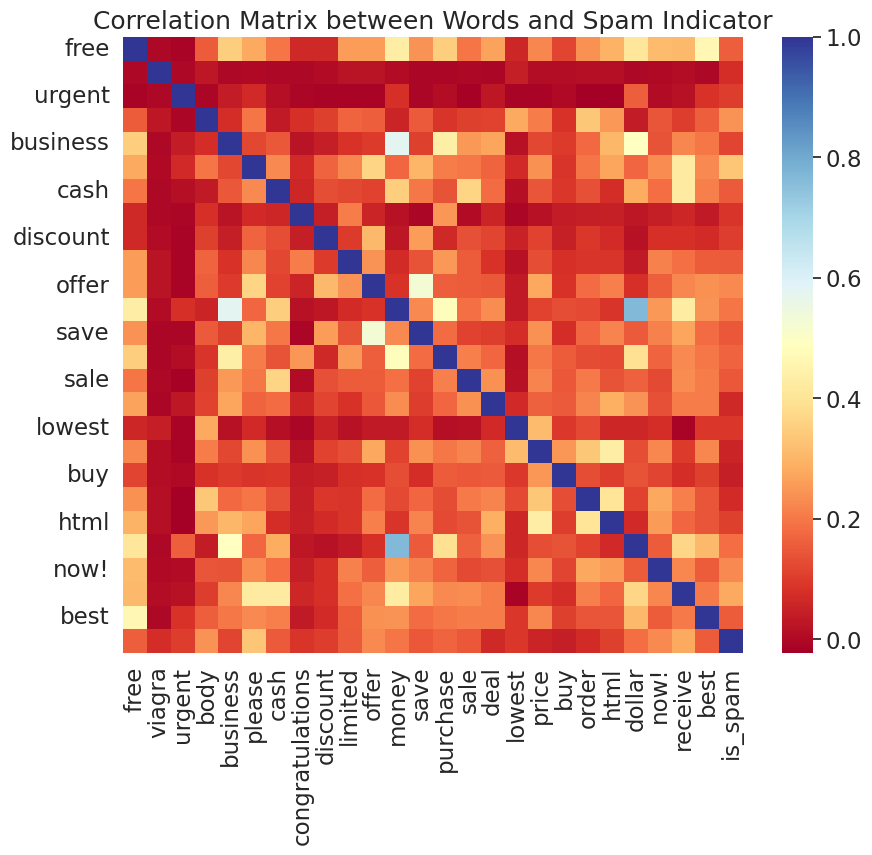

Text(0.5, 1.0, 'Distribution of the number of HTML tags for ham emails')

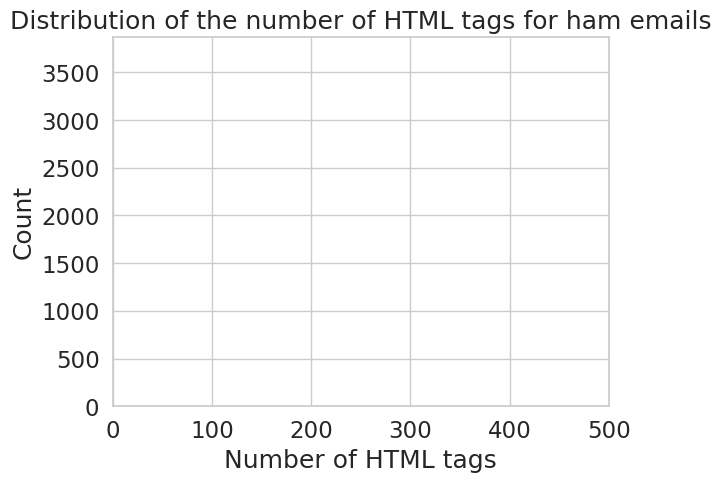

In [75]:
train_copy = train.copy()

train_copy["length_email"] = train_copy["email"].apply(len)
train_copy

sns.displot(data=train_copy, x="length_email", hue = "spam")
plt.xlim(0, 10000)
plt.xlabel("Length of email")
plt.title("Distribution of email lengths for spam and ham emails")

import re
train_copy_html = train.copy()

def count_HTML_tags(email_contents):
    html_tags = re.findall(r'<[^>]+>', email_contents)
    return len(html_tags)

train_copy_html['html_tag_count'] = train_copy_html['email'].apply(count_HTML_tags)
train_copy_html_spam = train_copy_html[train_copy_html["spam"] == 1]
train_copy_html_ham = train_copy_html[train_copy_html["spam"] == 0]

sns.displot(data=train_copy_html_spam, x="html_tag_count")
plt.xlim(0, 1100)
plt.xlabel("Number of HTML tags")
plt.title("Distribution of the number of HTML tags for spam emails")

spam_words = [
    "free",
    "viagra",
    "urgent",
    "body",
    "business",
    "please",
    "cash",
    "congratulations",
    "discount",
    "limited",
    "offer",
    "money",
    "save",
    "purchase",
    "sale",
    "deal",
    "lowest",
    "price",
    "buy",
    "order",
    "html",
    "dollar",
    "now!",
    "receive",
    "best"
]

train_spam_words = train.copy()


#word_counts = pd.DataFrame(index=train_spam_words.index, columns=spam_words, dtype=int)
word_counts = pd.DataFrame(words_in_texts(spam_words, train_spam_words['email']), columns=spam_words)


for word in spam_words:
    word_counts[word] = train_spam_words['email'].str.count(word)

word_counts['is_spam'] = train_spam_words['spam']
#spam_df = word_counts[word_counts['is_spam'] == 1]
correlation_matrix = word_counts.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='RdYlBu', annot = False)
plt.title('Correlation Matrix between Words and Spam Indicator')
plt.show()

sns.histplot(data=train_copy_html_ham, x="html_tag_count")
plt.xlim(0, 500)
plt.xlabel("Number of HTML tags")
plt.title("Distribution of the number of HTML tags for ham emails")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

---

## Question 1b

In two to three sentences, describe what you plotted and its implications with respect to your features.

In general, when we plot the distributions of email length for both spam and ham, we don't see that much of a difference in the overall distribution. While the frequencies of ham are so much larger (probably because there are more of them), the length of the email is probably not the best feature to use for classification. I also plotted a heat map with the correlations between the presence of specific words in an email, along with whether that email could be classified as spam or ham. In particular, when selecting specific features I looked for the words which had the brightest color with whether the email was spam or ham. These lighter features/words I selected to be in my model. I also plotted the distribution of the number of HTML tags for both spam and ham emails. I noticed that ham emails almost had NO HTML tags, and so looking forward I will look towards including a feature quantifying the number of HTML tags. 

<!-- END QUESTION -->

<br/>
<hr style="border: 1px solid #fdb515;" />

# Question 2: Building Your Own Model

Now that you've explored the data and relevant features through EDA, it's time to build your model! As mentioned earlier, you may use whatever method you prefer to create features, but **you may only use the packages we've imported for you in the cell below or earlier in this notebook**. In addition, **you are only allowed to train logistic regression models**. No decision trees, random forests, k-nearest-neighbors, neural nets, etc. 

Please consider the ideas mentioned above when choosing features. We have not provided any code to do this, so feel free to create as many cells as you need to tackle this task. 

In [76]:
# import libraries
# You may use any of these to create your features.
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import re
from collections import Counter

In [77]:
# Define your processing function, processed data, and model here. 
# You may find it helpful to look through the rest of the questions first!

best_words = ['please', "receive", 'body', "now!", 'offer', 'money', 'purchase', 'free', 'limited', "dollar", "best"]

for word in best_words:
    # Check if the word is present in each email content
    train[f'having_{word}'] = train['email'].str.contains(word).astype(int)
    test[f'having_{word}'] = test['email'].str.contains(word).astype(int)

train['html_tag_count'] = train['email'].apply(count_HTML_tags)
test['html_tag_count'] = test['email'].apply(count_HTML_tags)

train["length_email"] = train["email"].apply(len)
test['length_email'] = test['email'].apply(count_HTML_tags)



train['num_words'] = train['email'].apply(lambda x: len(x.split()))
test['num_words'] = test['email'].apply(lambda x: len(x.split()))

# Calculate the number of characters in each email content
train['num_characters'] = train['email'].apply(len)
test['num_words'] = test['email'].apply(lambda x: len(x.split()))

test

,id,subject,email,having_please,having_receive,having_body,having_now!,having_offer,having_money,having_purchase,having_free,having_limited,having_dollar,having_best,html_tag_count,length_email,num_words
0,0,Subject: CERT Advisory CA-2002-21 Vulnerabilit...,\n \n -----begin pgp signed message-----\n \n ...,1,1,1,0,0,0,0,1,1,0,1,2,2,1426
1,1,Subject: ADV: Affordable Life Insurance ddbfk\n,low-cost term-life insurance!\n save up to 70%...,0,0,0,0,1,0,0,1,0,0,0,0,0,99
2,2,Subject: CAREER OPPORTUNITY. WORK FROM HOME\n,------=_nextpart_000_00a0_03e30a1a.b1804b54\n ...,0,0,0,0,0,0,0,0,0,0,0,0,0,22
3,3,Subject: Marriage makes both sexes happy\n,"url: http://www.newsisfree.com/click/-3,848315...",0,1,0,0,0,0,0,1,0,0,0,0,0,24
4,4,Subject: Re: [SAtalk] SA very slow (hangs?) on...,on thursday 29 august 2002 16:39 cet mike burg...,0,0,0,0,0,0,0,0,0,0,0,1,1,129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,Subject: Re: Alsa/Redhat 8 compatability\n,"once upon a time, brian wrote :\n \n > \n > ...",0,0,0,0,0,0,0,0,0,0,0,1,1,229
996,996,Subject: Re: Goodbye Global Warming\n,\n --]> a green once said that if the spotted ...,0,0,0,0,0,0,0,0,0,0,0,0,0,45
997,997,Subject: Re: Entrepreneurs\n,"on fri, 23 aug 2002, robert harley wrote:\n \n...",0,0,0,0,0,0,0,0,0,0,0,0,0,97
998,998,Subject: Re: [ILUG] slashdot EW Dijkstra humor\n,jpl suggested:\n > recursion is only truely u...,0,0,0,0,0,0,0,0,0,0,0,1,1,113


<br>

---

# Question 3

### Grading Scheme

Your grade for this question will be based on your model’s accuracy when making predictions on the training set and your model’s accuracy when making predictions on the test set. The tables below provide scoring guidelines. If your accuracy lies in a particular range, you will receive the number of points associated with that range.

**Important**: While your training accuracy can be checked at any time in this notebook, your test accuracy can only be checked by submitting your model’s predictions to Gradescope. **You will only be able to submit your test set predictions to Gradescope up to 4 times per day**. In the case that you are approved for an extension, you are granted 4 more submissions for each day the deadline has been extended. Plan ahead to make sure you have enough time to fine-tune your model! The thresholds are as follows:

Points | 5 | 3 | 1.5 | 0
--- | --- | --- | --- | ---
**Training** Accuracy | 85% and Above | \[80, 85) | \[70, 80) | Below 70%

Points | 10 | 6 | 3 | 0
--- | --- | --- | --- | ---
**Testing** Accuracy | 85% and Above | \[80, 85) | \[70, 80) | Below 70%


<br><br>

---

## Question 3a: Train Predictions
Assign your predictions for the class of each data point in the training set `train` to `train_predictions`.

In [78]:
features = ["having_please","having_body","having_receive", "having_offer","having_now!", "having_money", "having_dollar", "length_email", "num_words"]

X2_train = train[features]
Y2_train = train["spam"]

lr_model = LogisticRegression()
#lr_model.fit(X2_train, Y2_train)

parameters = {'solver': ['lbfgs', 'liblinear', 'newton-cg', 'saga']}

grid = GridSearchCV(estimator=lr_model, param_grid=parameters)
grid_result = grid.fit(X2_train, Y2_train)

best_params = grid_result.best_params_

# Create a logistic regression model with the best hyperparameters
best_lr_model = LogisticRegression(**best_params)

# Train the logistic regression model on your training data
best_lr_model.fit(X2_train, Y2_train)

train_predictions = best_lr_model.predict(X2_train)

# Print your training accuracy. 
training_accuracy = np.mean(train_predictions == train["spam"]) #Switch copied back to train after
training_accuracy

/srv/conda/envs/notebook/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/srv/conda/envs/notebook/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/srv/conda/envs/notebook/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/srv/conda/envs/notebook/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Li

0.8557167576201251

In [79]:
grader.check("q3a")

q3a results: All test cases passed!

<br>

---

## Question 3b: Test Predictions

The following code will write your predictions on the test dataset to a CSV file. **You will need to submit this file to the "Project B2 Test Set Predictions" assignment on Gradescope to get credit for this question.**

Assign your predictions for the class of each datapoint in the test set `test` to a 1-dimensional array called `test_predictions`. **Please make sure you save your predictions to `test_predictions`, as this is how part of your score for this question will be determined.**

**Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the test data in order to make predictions.** For example, if you've created features for the words "drug" and "money" on the training data, you must also extract the same features in order to use `scikit-learn`'s `.predict` method.

**Gradescope limits you to 4 submissions per day to meet the threshold.** If you are approved for an extension, you are granted 4 more submissions for each day the deadline has been extended.

The provided tests check that your predictions are in the correct format but are worth 0 points in the *Project B2 Coding assignment*. To evaluate your classifier accuracy, you must submit the CSV file to the *Project B2 Test Set Predictions* assignment.

In [80]:
test_train = test[features]

#test_predictions = simple_model.predict(X2_train)
test_predictions = best_lr_model.predict(test_train)

In [81]:
grader.check("q3b")

q3b results: All test cases passed!

The following cell generates a CSV file with your predictions. **You must submit this CSV file to the "Project B2 Test Set Predictions" assignment on Gradescope to get credit for this question.** You can only submit to Gradescope a maximum of 4 times per day, so please use your submissions wisely!

In [82]:
# Assuming that your predictions on the test set are stored in a 1-dimensional array called
# test_predictions. Feel free to modify this cell as long you create a CSV in the right format.

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = "submission_{}.csv".format(timestamp)
submission_df.to_csv(filename, index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
display(HTML("Download your test prediction <a href='" + filename + "' download>here</a>."))
print('You may now upload this CSV file to Gradescope for scoring.')#

Created a CSV file: submission_20240424_190916.csv.


You may now upload this CSV file to Gradescope for scoring.


<br/>
<hr style="border: 1px solid #fdb515;" />

# Analyzing Your Model

Congratulations on completing your model! In the next few questions, we'll ask you to comment on your process for building a successful model and better understand the amount of misclassifications your model makes. 

<!-- BEGIN QUESTION -->

<br>

---

# Question 4

Describe the process of improving your model. You should use at least 2-3 sentences each to address the following questions:

1. How did you find better features for your model?
2. What did you try that worked or didn't work?
3. What was surprising in your search for good features?

Besides looking at how the accuracy changed with specific features, I also made use of some more EDA. In particular, I decided to keep adding more features to my heat map and look for the correlation between *that* specific feature and whether the email is spam or ham. I also made specific features looking at total characters, total words, and specific characters like "<" or "!". The main thing I noticed, however, was that a lot of these features like "total characters" or "number of HTML" tags, while they did have *some* impact, it wasn't as big as the specific words. As a result, I tried to favor specific **spam** words as my features. The specific feature of "having_receive", or the feature indicating if an email contained the word "receive," really surprised me. I didn't really associate this word as a **spammy** word, so it pleasantly surprised me when I saw its impact on the accuracy of the model. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

---

# Question 5: ROC Curve

In most cases, we won't be able to get 0 false positives and 0 false negatives, so we have to compromise. For example, in the case of cancer screenings, false negatives are comparatively worse than false positives — a false negative means that a patient might not discover that they have cancer until it's too late. In contrast, a patient can receive another screening for a false positive.

Recall that logistic regression calculates the probability that an example belongs to a particular class. To classify an example, we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. However, **we can adjust that cutoff threshold**. We can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam, for example. This is how we can trade off false positives and false negatives.

The Receiver Operating Characteristic (ROC) curve shows this trade-off for each possible cutoff probability. In the cell below, plot an ROC curve for your final classifier (the one you use to make predictions for Gradescope) on the training data. [Lecture 23](https://ds100.org/sp24/lecture/lec23/) may be helpful.

**Hint**: You'll want to use the `.predict_proba` method [(documentation)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba) for your classifier instead of `.predict` to get probabilities instead of binary predictions.

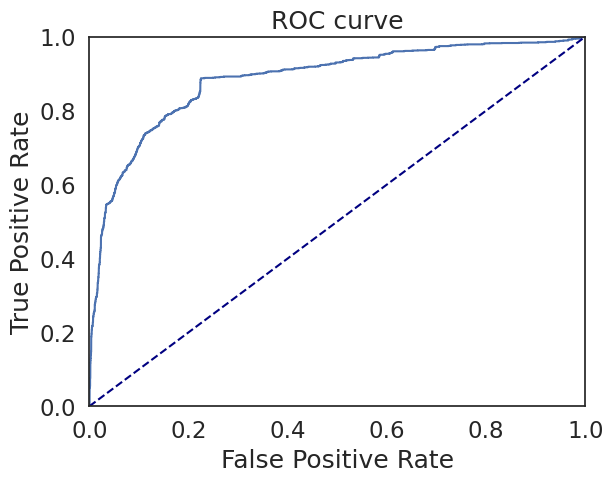

In [83]:
Y_predict = best_lr_model.predict_proba(X2_train)[:,1]
fpr, tpr, thresholds = roc_curve(Y2_train, Y_predict)
with sns.axes_style("white"):
    plt.plot(fpr, tpr)
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Guess')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

<!-- END QUESTION -->

<br/>
<hr style="border: 1px solid #fdb515;" />

# Diving Deeper

So far, we’ve been looking at our model through the lens of accuracy. In the next two questions, we'll dive deeper into the complexities of analyzing our model's performance. In particular, we'll ask you to explore some ambiguous cases that can arise, even within the training data itself, and the consequences of misclassification. You may have already come across some of these cases unknowingly when building your model!

<br><br>

---

## Question 6

To help you better understand some of the challenges that arise with classification, we've selected three emails from the `train` `DataFrame` and provided them below. Each email highlights a different issue that could arise. Skim through each of the emails below before answering part a).

### Example 1

In [84]:
# Just run this cell, don't modify it.

print("spam: " + str(train.loc[5216]["spam"]))
print("\nemail:\n" + train.loc[5216]["email"])

spam: 1

email:
hello you two,
 
 i am so sorry catherine for not writing recently. i have just been vv busybeing a working mother and sometimes it all gets too much you know!! i cannot wait to see you both although we may meet at the airport on the 16/6 as that's the day we're going to france but i will see you both at bronagh's house for her 30th which we're going to on the way back from the airport. i am so excited about seeing you!!! liitle eva ( aine) was born on tuesday
  she is absolutely incredible. poor bronagh is 11 dsays over!!
 sounds like you've been having an amazing time. hope you won't be too depressed to be back!!
 
 lots of love
 
 deirdre
 "justin mason" <jm@jmason.org> wrote:
 
 <  
 <  just a quick note -
 <  
 <  we've decided to go up to annapurna base camp instead of
 <  the jomsom trek - it's a bit more impressive visually
 <  (if a little soggier).   so as of tomorrow morning, ourselves
 <  and our guide bhadra will be leaping like gazelles up 4000-odd
 <  met

### Example 2

In [85]:
# Just run this cell, don't modify it.

print("spam: " + str(train.loc[36]["spam"]))
print("\nemail:\n" + train.loc[36]["email"])

spam: 0

email:
lifetime movie newsletter
 
 this week's movies to watch on lifetime
 
 [ http://www.lifetimetv.com/movies/index.html ]
 
 august 19, 2002
 
 *************************************************************************
 
 coming at you this week...
 
 1) "the secret life of zoey" premiere!
 2) the buzz about the upcoming movie
 3) movies airing this week
 4) big event: a martinez sunday
 5) fun and games
 
 *************************************************************************
 
 "the secret life of zoey" premiere!
 
 take a sneak peek at lifetimes next exciting original movie, "the secret life of zoey" [ http://www.lifetimetv.com/movies/info/move3195.html ], airing on monday, august 19 at 9 pm et/pt. zoey's mom thought she knew everything about her perfect teenage daughter. but when she realizes that her child is addicted to drugs, both of their worlds spin out of control. this dramatic film delves into the topic of teenage drug addiction and features stellar performer

### Example 3

In [86]:
# Just run this cell, don't modify it.

print("spam: " + str(train.loc[1092]["spam"]))
print("\nemail:\n" + train.loc[1092]["email"])

spam: 0

email:
this is a multi part message in mime format.
 
 --_nextpart_1_bvfoditvghtocxfdvjnkcuwblfv
 content-type: text/plain; charset="us-ascii"
 content-transfer-encoding: 7bit
 
 ........... with our telecoms partner bumblebee !
 
 don't get ripped off by expensive hotel, payphone and mobile charges. 
 save, save, save on international calls with ryanair's phone partner. 
 ************************************************************************
 *********
 
 you'll save up to 70% on international phone calls when you use our 
 online phone card.  you can use the card from any phone in any country 
 you visit and you won't have to worry about high phone charges 
 when you call home or the office.
 
 buying a card couldn't be easier and it's totally secure.  simply go to
 http://www.bumblebeecommunications.com/lowcostcalls/  
  to avail of this special offer for ryanair customers.
 
 it's another great deal from ryanair and our online phone 
 partner, bumblebee communications. 


<!-- BEGIN QUESTION -->

### Question 6a

Pick at least **one** of the emails provided above to comment on. How would you classify the email (e.g., spam or ham), and does this align with the classification provided in the training data? What could be a reason someone would disagree with *your* classification of the email? In 2-3 sentences, explain your perspective and potential reasons for disagreement.

I pick email 2. I would personally classify this email as "spam". This does NOT align with the classification provided in the training data, as in the training data it is considered "ham". Someone would perhaps disagree with the email being considered spam, and thus be in favor of ham, due to a couple of reasons. 1) the email has a disclaimer - something you would normally see from an established/credible email address. 2) The beginning of the email states that the contents of the message are in MIME format. After a quick Google Search on what MIME format is, the MIME format is typically used for sending over specific attachments. That could possibly explain the whole jumble of random characters at the end. 

The reason I think this is spam is because this email is *trying* to sell you something. In particular, it's trying to sell something to someone with no prior contact with the company at all. There's no acknowledgment from the company that the recipient of this email is indeed a customer, but they instead go right on ahead in marketing their services. The words "offer", "totally secure", and "save" are common words present in spam emails as well. Furthermore, the formatting of the "****" characters isn't very common in most emails, which could also suggest that this is some kind of spam. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6b

As data scientists, we sometimes take the data to be a fixed “ground truth,” establishing the “correct” classification of emails. However, as you might have seen above, some emails can be ambiguous; people may disagree about whether an email is actually spam or ham. How does the ambiguity in our labeled data (spam or ham) affect our understanding of the model's predictions and the way we measure/evaluate our model's performance?

If there are ambiguities within our data that we are assuming to be the "ground truth," then that would also have implications for our model's output. If to begin with, our data is already ambiguous, then it likewise follows that our model would create outputs that are also ambiguous. It goes back to the saying "you get in what you get out." So, we always need to take our model's predictions with a grain of salt. Let's say that we have some data that has labels that are inherently misclassified. If we build our classification model on that kind of data, then the model we create will also misclassify those kinds of data points in our testing set. So even though the accuracy might be great, since our data was fundamentally incorrect / misclassified to begin with, the output would also follow the same behavior of being incorrect. Suffice it to say that **if** there is no "common ground"(where our data is ambiguous), then we're kind of shooting in the dark. 

<!-- END QUESTION -->

As a data scientist, we encourage you to think more critically about your data before establishing it as the "ground truth." Whenever you're working on a specific problem, ask yourself:  
1. Who “made” the data? Think about all the stages from when it was first generated, collected, and labeled before it ended up in a CSV file.
2. What assumptions and biases are inherently present in the data?
3. And finally, how does all this affect how you interpret your model’s performance?

<br><br>

---

## Question 7

In Question 6, we explored the instability present in the “ground truth” and how this affects our evaluation of our model. Now, let's start thinking about your model's interpretability and what that means more broadly for an email classification task. A model is considered interpretable if humans can easily understand the reasoning behind its predictions and classifications.

### Question 7a

First, let's see if we can understand how our choice of features relates to how a particular email is classified. 

#### Part i

Let’s take a look at the `simple_model` we provided you earlier that uses 5 features. We have provided the code below for ease of reference. You will examine how a particular feature influences how an email is classified. 

In [87]:
# Simple model introduced at the start of this notebook. Just pay attention to the features.
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = np.array(train['spam'])

simple_model = LogisticRegression()
simple_model.fit(X_train, Y_train);

Pick an email from the training set and assign its index to `email_idx`. Then, find **one** feature used in `simple_model` such that **removing** it changes how that email is classified. Assign this feature to  `feature_to_remove`.

In [88]:
# Use this cell for scratch work when determining `email_idx`
filtered_df = train[train['email'].str.contains("pharmacy")]
filtered_df.head()

,id,subject,email,spam,having_please,having_receive,having_body,having_now!,having_offer,having_money,having_purchase,having_free,having_limited,having_dollar,having_best,html_tag_count,length_email,num_words,num_characters
92,4755,Subject: A Situation That Could Revolutionize ...,"date: tuesday, july 9, 2002<br><br>\n <br><!do...",1,1,0,1,0,1,1,0,0,1,1,0,325,14854,1413,14854
397,2471,Subject: Re: Without a Perscription - VIAGRA /...,"<html>\n <head>\n </head>\n <body bgcolor=3d""#...",1,1,1,1,0,1,0,0,1,0,0,1,201,6449,585,6449
931,1880,Subject: [ILUG] Love Pill Vaaa...i..g.. - Onli...,now on sale for $129.00 10 100 mg tablets\n \n...,1,1,1,0,0,0,1,0,0,0,0,1,0,1281,163,1281
1031,5271,Subject: PLEASURE YOUR WOMEN FOR HOURS WITH VI...,\n <html>\n <body>\n <body>\n \n <table border...,1,1,0,1,0,1,0,0,1,0,0,0,155,4404,331,4404
1208,5808,Subject: bhgb\n,"<html>\n <head>\n <meta http-equiv=""content-la...",1,1,1,1,0,1,0,0,1,0,0,1,201,6148,669,6148


In [89]:
email_idx = 92

prob_spam = simple_model.predict_proba(X_train)[:, 1]
initial_prob = prob_spam[email_idx]
initial_class = "spam" if np.round(initial_prob) else "ham"
print(f"\nPredicted probability of being spam: {np.round(initial_prob*100, 2)}%")
print("\nEmail:\n" + train.loc[email_idx]["email"])


Predicted probability of being spam: 43.39%

Email:
date: tuesday, july 9, 2002<br><br>
 <br><!doctype html public '-//w3c//dtd html 4.01 transitional//en'>
 <html>
 <head>
 <title>ibxg e-mailer 7/9/02</title>
 <meta http-equiv='content-type' content='text/html; charset=iso-8859-1'>
 </head>
 
 <body>
 <table width='90%' border='1' align='center' cellpadding='3' cellspacing='3' bordercolor='#000099'>
   <tr>
     <td><div align='center'> <div align='center'> <font size='1' face='arial, helvetica, sans-serif'><strong><em><font size='2' face='georgia, times new roman, times, serif'>rapid 
         growth health care company: stock symbol ibxg trading around<font size='3' face='times new roman, times, serif'> 
         16</font> cents</font></em></strong></font><br>
         <br>
         <font color='#000099' size='7' face='times new roman, times, serif'> 
         market watch corporation</font><br>
         <font size='1' face='arial, helvetica, sans-serif'><br>
         <strong><font

In [90]:
#'drug', 'bank', 'prescription', 'memo', 'private']

feature_to_remove = "bank"

changed_words = some_words.copy()
changed_words.remove(feature_to_remove)

changed_model = LogisticRegression()
X_changed = words_in_texts(changed_words, train['email'])
y = train['spam']
changed_model.fit(X_changed, y)
changed_prob = changed_model.predict_proba(X_changed[[email_idx]])[:,1][0]
changed_class = "spam" if np.round(changed_prob) else "ham"

print(f"Initially classified as {initial_class} (Probability: {np.round(initial_prob*100, 2)}%)")
print(f"Now classified as {changed_class} (Probability: {np.round(changed_prob*100, 2)}%)")

Initially classified as ham (Probability: 43.39%)
Now classified as spam (Probability: 50.38%)


In [91]:
grader.check("q7ai")

q7ai results: All test cases passed!

<!-- BEGIN QUESTION -->

#### Part ii

In 2-3 sentences, explain why you think the feature you chose to remove changed how your email was classified.

I chose 'bank' as the odd word out, or the feature I chose to omit. I noticed that the words 'drug', 'prescription', 'memo', and 'private' had some similarities. In particular, I associated these words with the topic of healthcare. In particular, the first thing I thought of was 'pharmacy' in particular. I looked for specific emails that contained the word "pharmacy", and chose the first email I saw in the list.

In many spam emails relating to healthcare, or specifically in emails that try to sell you some kind of magic pill, I do not think "bank" would appear that much. "Bank" would be more indicative of financial emails, where maybe someone's trying to pretend to be your bank, someone's trying to trick you into sending them money, or just some other kind of financial spam email. So by removing the term "bank", the model was able to hone in on more of the healthcare spam words, and thus classify the email more accurately. The reason I say "more accurately" is because I believe this specific email is indeed a spam email. 

<!-- END QUESTION -->

### Question 7b

Now, let's say that instead of working with a small model containing 50-100 features, you're working with a much larger, more accurate model containing 1000 features. 

<!-- BEGIN QUESTION -->

#### Part i
In this context, do you think you could easily find a feature that could change an email's classification as you did in part a)? Why or why not?

In general, I think that if we had a more accurate model containing 1000+ features, it would generally be hard to find a specific feature which could change an email's classification. My reasoning for this is because for a larger model like this, each feature relative to the others, plays a much smaller role than it did in the 50-100 features. Furthermore, with amost 10 times the features, the more accurate model would capture more of the nuances within our original data. As a result, finding *a particular* feature that would drastically change the classifier's ability, I think is very unlikely. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### Part ii 
Would you expect this new model to be more or less interpretable than `simple_model`?

**Note**: A model is considered interpretable if you can easily understand the reasoning behind its predictions and classifications. For example, the model we saw in part a), `simple_model`, is considered interpretable as we can identify which features contribute to an email's classification.

I would expect that for this new model to be *less* interpretable that `simple_model`. Since `simple_model` only contains 5 features, it would be much easier to pinpoint which features are resulting in which specific behaviors. In other words, it would be a lot easier to see the influence of each feature on the classification decision. With a model containing 1000 features, the model would be more complex and thus more accustomed to the data. Due to the large number of features, I believe it would be a lot harder to interpret which specfic features lead to what specific behaviors in contributing to an email's classification

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 7c

Now, imagine you’re a data scientist at Meta, developing a text classification model to decide whether to remove certain posts / comments on Facebook. In particular, you’re primarily working on moderating the following categories of content:
* Hate speech
* Misinformation 
* Violence and incitement

Pick one of these types of content to focus on (or if you have another type you’d like to focus on, feel free to comment on that!). What content would fall under the category you’ve chosen? Refer to Facebook’s [Community Standards](https://transparency.fb.com/policies/community-standards/), which outline what is and isn’t allowed on Facebook. 

I decided to select the topic of hate speech. The specific content I would classify under hate speech would include tweets containing racial slurs, derogatory language towards a specific ethnicity, expressions meant to humiliate a specific gender / sexuality, and speech that is also meant to bring hate towards a specific religion, country of origin, or disability. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 7d

What are the stakes of misclassifying a post in the context of a social media platform? Comment on what a false positive or false negative means for the category of content you’ve chosen (hate speech, misinformation, or violence and incitement).

Misclassifying a post as "not hate speech" when in reality it is "hate speech", can do many detrimental things on a social media platform. The first concern is that these posts incite specific feelings towards a specific group. There are many people online, and so if many minds read the same post containing hate speech about a specific group, in some cases it may create unconscious bias in the users reading the post, and for others it may breed into full-on hatred. Furthermore, having posts like these misclassified also would enforce the idea that hate speech is the norm. Even for the groups being targeted, I would predict they would feel marginalized, silenced, and unsafe to be on this social media platform, which could lead to a different set of issues such as anxiety or depression. 

For this let's assume that the presence of hate speech is "positive" (Class 1). Regarding the topic of hate speech, a false positive would indicate that a normal post, with no hate speech at all, would be classified as being hate speech. Thus, this ordinary post would be censored by the classifier. On the other side of things, a false negative would indicate that a post containing hate speech would be classified as NOT, and would be visible for the whole internet to see

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 7e

As a data scientist, why might having an interpretable model be useful when moderating content online?

Having an interpretable model would promote transparency into the specific features with which the classification of this model works online. So, if the model seems to output many errors in moderating specific content, it would be a lot easier to pinpoint *why* specifically that behavior is happening. As a result of this, an interpretable model will also make the revision process a lot easier. When we're trying to improve our model to limit a specific kind of bias, interpretability would make the process much more straightforward. Furthermore, with this kind of open-book model, the specific social media platforms deploying this model will be directly held accountable for their actions. If the general masses can understand what goes behind these specific models, it would be a lot easier to ensure that if the model is bad, action is taken.

<!-- END QUESTION -->

As you explored throughout this question, interpretability is incredibly important. However, it is equally important to note that interpretability on its own isn’t a fix to all the problems that may arise when moderating content or when building a model more generally. As we touched on in Project A2, these models don’t operate in a vacuum; they exist in a wider sociotechnical system. Everything from the data used to train these models to the metrics we choose to evaluate our models builds on that notion.

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Mimi and Trouble congratulate you for finishing Project B2!

<div align="middle">
    <table style="width:75%">
      <tr align="center">
        <td><video controls src = "images/mimi.mp4" width = "250">animation</video>
        <td><img src="images/trouble2.jpeg" align="middle" width="325vw"/>
        <td><img src="images/trouble.jpeg" align="middle" width="325vw"/>
      </tr>
    </table>
  </div>

### Course Content Feedback

If you have any feedback about this assignment or about any of our other weekly, weekly assignments, lectures, or discussions, please fill out the [Course Content Feedback Form](https://docs.google.com/forms/d/e/1FAIpQLSe0fBEJwt6aEfZxU3fh3llNk8rSWHj6Umq0km3wPqmFu0MlGA/viewform). Your input is valuable in helping us improve the quality and relevance of our content to better meet your needs and expectations!

### Submission Instructions

Below, you will see a cell. Running this cell will automatically generate a zip file with your autograded answers. Once you submit this file to the Project B2 Coding assignment on Gradescope, Gradescope will automatically submit a PDF file with your written answers to the Project B2 Written assignment. If you run into any issues when running this cell, feel free to check this [section](https://ds100.org/debugging-guide/autograder_gradescope/autograder_gradescope.html#why-does-grader.exportrun_teststrue-fail-if-all-previous-tests-passed) in the Data 100 Debugging Guide.

If there are issues with automatically generating the PDF, you can try downloading the notebook as a PDF by clicking on `File -> Save and Export Notebook As... -> PDF`. If that doesn't work either, you can manually take screenshots of your answers to the manually graded questions and submit those. 

**Please make sure you submit the following to the right assignments:**

* **Project B2 Coding:** Submit the zip file generated by using the `grader.export()` cell provided below.
* **Project B2 Written:** Gradescope will automatically submit the PDF from the zip file submitted earlier. You do not need to submit anything to this assignment yourself, but *please check that the submission went through properly and that all plots rendered correctly*.
* **Project B2 Test Set Predictions:** Submit the CSV file generated in `q3b`.

**You are responsible for ensuring your submission follows our requirements and that everything was generated and submitted correctly. We will not be granting regrade requests nor extensions to submissions that don't follow instructions.** If you encounter any difficulties with submission, please don't hesitate to reach out to staff prior to the deadline. 

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [92]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q3a results: All test cases passed!

    q3b results: All test cases passed!

    q7ai results: All test cases passed!
